# AI for Search and Optimisation – Practical Portfolio
## Travelling Salesman Problem (TSP)

**Student Name:** Swatej Parmar  
**Student ID:** 25042860  
**Module:** UFCEL1-15-M   


In [61]:

#Importing Libraries

#Using the numpy for numerical opration 
import numpy as np
#Using the panda for data manipulation 
import pandas as pd
#Using the matplotlib.pyplot we can create interactive visualization
import matplotlib.pyplot as plt
# Time we are using for the time related task
import time
  

In [62]:
# Load the TSP dataset

df = pd.read_csv("AI Project/cities.csv")

# Displaying the first few rows
#head() displays the first few rows to confirm the data loaded correctly
df.head()


,City,X,Y
0,City_1,37.454012,95.071431
1,City_2,73.199394,59.865848
2,City_3,15.601864,15.599452
3,City_4,5.808361,86.617615
4,City_5,60.111501,70.807258


## Define the TSP Problem

In [63]:
# Extracting city coordinates
coords = df[["X", "Y"]].values

# Function to compute straight-line (Euclidean) distance between two cities.
def euclidean_distance(p1, p2):
    return np.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

# Build distance matrix
# dist[i][j] = distance from city i to city j.
def build_distance_matrix(coords):
    n = len(coords)
    dist_matrix = np.zeros((n, n))
#This avoids recalculating distances many times.
    for i in range(n):
        for j in range(n):
            dist_matrix[i, j] = euclidean_distance(coords[i], coords[j])

    return dist_matrix

# Createing the distance matrix
dist_matrix = build_distance_matrix(coords)

# Show matrix shape
dist_matrix.shape


(50, 50)

In [104]:
# calculating  the total length of a the tour
# It adds up distances between consecutive cities

def tour_length(route, dist):
    total = 0.0
    for i in range(len(route) - 1):
        total += dist[route[i], route[i + 1]]
    total += dist[route[-1], route[0]]  # return to start
    return total

## Test with a Random Solution

In [65]:
# Creating a random route

n_cities = len(coords)
random_route = np.random.permutation(n_cities)

# Compute the total tour length of this random route
tour_length(random_route, dist_matrix)


2647.0030798308912

In [66]:
# Testing the tour_length function
n_cities = len(coords)
random_route = np.random.permutation(n_cities)

distance = tour_length(random_route, dist_matrix)
print("Total tour length:", distance)


Total tour length: 2481.711260351637


# Step 1: SIMULATED ANNEALING
### Neighbour Generation (2-opt swap)

Simulating Annealing is a metaheuristic search technique model after the heating and cooling of metals. It shows that the process with one route and subsequently enhances it through minor modifying. Occasionally acceptance of lower solutions according to the current temperature value is a strategy that help in the algorithm avoid local optima. As the temperature lowers, the technique becomes choosier and gradually approaches a consistent, top-notch tour.

In [67]:
# Generate a neighbour using 2-opt swap

#This simply reverses a portion of the route to explore a new path

def two_opt_swap(route):
    i, j = np.random.choice(len(route), 2, replace=False)
    if i > j:
        i, j = j, i
    new_route = route.copy()
    new_route[i:j] = route[i:j][::-1]
    return new_route


### Acceptance Probability Function

In [68]:
# Acceptance probability function
# At high temperature → worse solutions are more likely accepted
# At low temperature → acceptance becomes strict

def acceptance_probability(current_cost, neighbour_cost, temperature):
    if neighbour_cost < current_cost:
        return 1.0
    return np.exp((current_cost - neighbour_cost) / temperature)


### Simulated Annealing Algorithm

In [103]:
#In the SA algorithm
#Its with the Start with a random route
#Repeatedly generate neighbours using 2-opt
#Accept better solutions automatically
#Sometimes accept worse solutions based on temperature

def simulated_annealing(dist_matrix, 
                         initial_temp=1000, 
                         cooling_rate=0.995, 
                         max_iterations=50000):
    
    n_cities = len(dist_matrix)
    current_route = np.random.permutation(n_cities)
    current_cost = tour_length(current_route, dist_matrix)

    best_route = current_route.copy()
    best_cost = current_cost

    history = []
    temperature = initial_temp

    for iteration in range(max_iterations):
        neighbour = two_opt_swap(current_route)
        neighbour_cost = tour_length(neighbour, dist_matrix)

        if np.random.rand() < acceptance_probability(current_cost, neighbour_cost, temperature):
            current_route = neighbour
            current_cost = neighbour_cost

        if current_cost < best_cost:
            best_route = current_route.copy()
            best_cost = current_cost
#Gradually cool down until convergence
        history.append(best_cost)
        temperature *= cooling_rate

        if temperature < 1e-3:
            break

    return best_route, best_cost, history


### Run Simulated Annealing

In [70]:
# Run the SA algorithm and record the best route, distance, and history
start_time = time.time()

sa_route, sa_cost, sa_history = simulated_annealing(dist_matrix)

end_time = time.time()

print("Best tour length (SA):", sa_cost)
print("Execution time (seconds):", round(end_time - start_time, 3))


Best tour length (SA): 702.9216482444232
Execution time (seconds): 0.166


### Convergence Plot

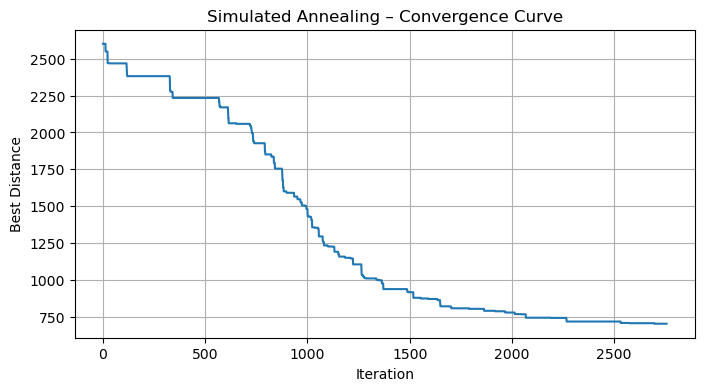

In [71]:
#Plot how the best distance improves over iterations

plt.figure(figsize=(8,4))
plt.plot(sa_history)
plt.title("Simulated Annealing – Convergence Curve")
plt.xlabel("Iteration")
plt.ylabel("Best Distance")
plt.grid(True)
plt.show()


### Plot Best Route

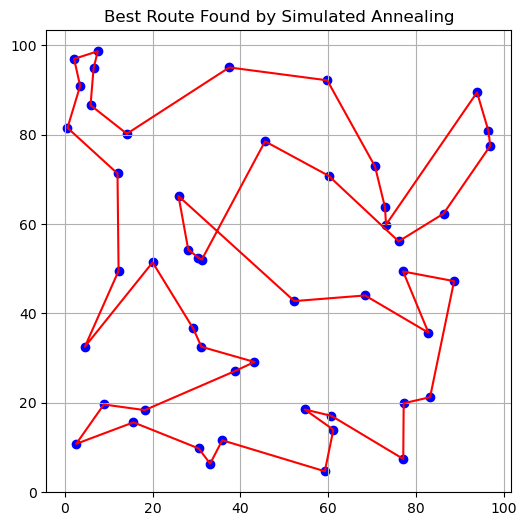

In [72]:
#Draws the best tour found by SA

ordered_coords = coords[list(sa_route) + [sa_route[0]]]

plt.figure(figsize=(6,6))
plt.scatter(coords[:,0], coords[:,1], c="blue")
plt.plot(ordered_coords[:,0], ordered_coords[:,1], c="red")
plt.title("Best Route Found by Simulated Annealing")
plt.grid(True)
plt.show()


# Step 2 – GENETIC ALGORITHM FOR TSP

### Genetic Algorithm (Population-Driven Search)


A Genetic Algorithm is an optimization method that mimics the processes of nature, with the underlying principle derived from survival of the fittest. The method involves that evolving a group of potential routes over the years through the application of selection, crossover, and mutation processes.

Each route corresponds to a valid city permutation, and the total length of the tour is used to assess the fitness.


### Initial Population

In [88]:
#Creates a population of random tours for GA
def create_population(pop_size, n_cities):
    return [np.random.permutation(n_cities) for _ in range(pop_size)]


### Fitness Function

In [89]:
# Fitness function (inverse of tour length)
# Shorter tours = higher fitness
def fitness(route, dist):
    return 1 / tour_length(route, dist)


### Selection (Tournament Selection)

In [90]:
#Selects the best individual from a random mini-group
#Mimics “survival of the fittest”.
def tournament_selection(population, dist, k=5):
    selected = np.random.choice(len(population), k, replace=False)
    best = population[selected[0]]
    best_fit = fitness(best, dist)

    for idx in selected[1:]:
        if fitness(population[idx], dist) > best_fit:
            best = population[idx]
            best_fit = fitness(population[idx], dist)

    return best.copy()


### Ordered Crossover

In [91]:
# Produces a child by inheriting a section from parent1
# and filling the rest from parent2 without duplicates

def order_crossover(parent1, parent2):
    n = len(parent1)
    a, b = sorted(np.random.choice(n, 2, replace=False))

    child = [-1] * n
    child[a:b] = parent1[a:b]

    fill = [gene for gene in parent2 if gene not in child]
    idx = 0
    for i in range(n):
        if child[i] == -1:
            child[i] = fill[idx]
            idx += 1

    return np.array(child)


### Swap Mutation

In [92]:
# Randomly swaps two cities in a route with some probability

def mutate(route, mutation_rate=0.1):
    if np.random.rand() < mutation_rate:
        i, j = np.random.choice(len(route), 2, replace=False)
        route[i], route[j] = route[j], route[i]
    return route


### Genetic Algorithm

In [93]:
# Main GA Algorithm
# Create population
# Select parents
# Apply crossover
# Apply mutation
# Replace old population

# Now Tracking best solution

def genetic_algorithm(dist_matrix, 
                      pop_size=100,
                      generations=300,
                      mutation_rate=0.1):
    
    n_cities = len(dist_matrix)
    population = create_population(pop_size, n_cities)

    best_route = None
    best_cost = float("inf")
    history = []

    for gen in range(generations):
        new_population = []

        # Elitism: zlution
        population.sort(key=lambda r: tour_length(r, dist_matrix))
        if tour_length(population[0], dist_matrix) < best_cost:
            best_route = population[0].copy()
            best_cost = tour_length(best_route, dist_matrix)

        history.append(best_cost)
        new_population.append(best_route)

        while len(new_population) < pop_size:
            p1 = tournament_selection(population, dist_matrix)
            p2 = tournament_selection(population, dist_matrix)

            child = order_crossover(p1, p2)
            child = mutate(child, mutation_rate)

            new_population.append(child)

        population = new_population

    return best_route, best_cost, history


# Run GA

In [99]:
# Run the Genetic Algorithm
# GA works by evolving a population of routes over many generations
# Capture the best route found, its distance, and the runtime

start_time = time.time()

ga_route, ga_cost, ga_history = genetic_algorithm(dist_matrix)

end_time = time.time()

print("Best tour length (GA):", ga_cost)
print("Execution time (seconds):", round(end_time - start_time, 3))


Best tour length (GA): 702.0072810319767
Execution time (seconds): 12.95


### GA Convergence Plot

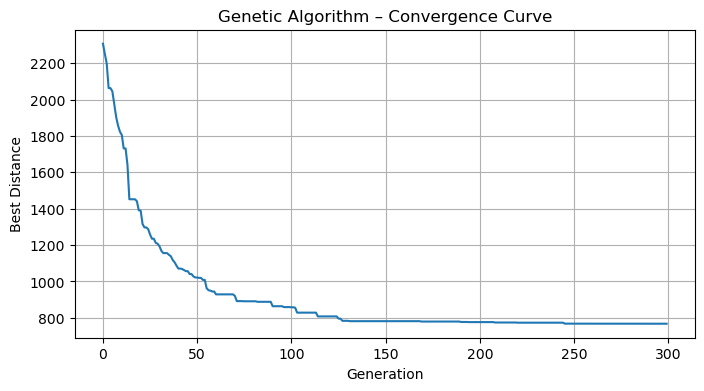

In [80]:
# Plot the convergence curve of the Genetic Algorithm
# A downward trend means the GA is learning and producing better solutions over time

plt.figure(figsize=(8,4))
plt.plot(ga_history)
plt.title("Genetic Algorithm – Convergence Curve")
plt.xlabel("Generation")
plt.ylabel("Best Distance")
plt.grid(True)
plt.show()


### Plot GA Best Route

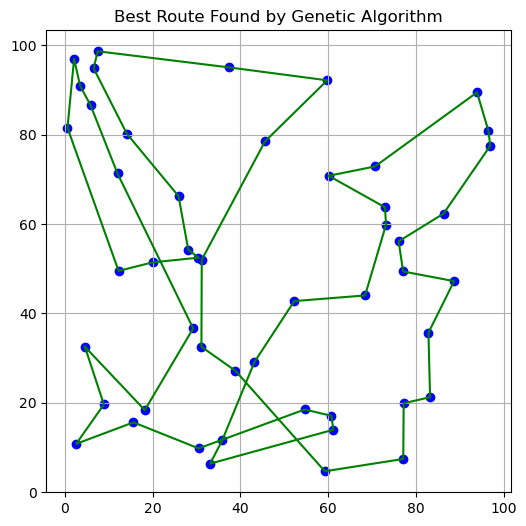

In [81]:
# Visualize the best tour found by the Genetic Algorithm
# We add the first city at the end to close the loop 
ordered_coords_ga = coords[list(ga_route) + [ga_route[0]]]

plt.figure(figsize=(6,6))
plt.scatter(coords[:,0], coords[:,1], c="blue")
plt.plot(ordered_coords_ga[:,0], ordered_coords_ga[:,1], c="green")
plt.title("Best Route Found by Genetic Algorithm")
plt.grid(True)
plt.show()


### STEP 3 — Comparison: SA vs GA

### Comparison Table

In [102]:
#Creating a comparison table for the two algorithms

comparison_df = pd.DataFrame({
    "Algorithm": ["Simulated Annealing", "Genetic Algorithm"],
    "Best Distance": [sa_cost, ga_cost],
})

# Display the comparison table so we can clearly see which algorithm found the shorter route.\
comparison_df


,Algorithm,Best Distance
0,Simulated Annealing,702.921648
1,Genetic Algorithm,702.007281


### Execution Time Comparison

In [83]:
# Time Simulated Annealing
start = time.time()
_, sa_cost_tmp, _ = simulated_annealing(dist_matrix)
sa_time = time.time() - start

# Time Genetic Algorithm
start = time.time()
_, ga_cost_tmp, _ = genetic_algorithm(dist_matrix)
ga_time = time.time() - start

time_df = pd.DataFrame({
    "Algorithm": ["Simulated Annealing", "Genetic Algorithm"],
    "Execution Time (seconds)": [sa_time, ga_time]
})

time_df


,Algorithm,Execution Time (seconds)
0,Simulated Annealing,0.212437
1,Genetic Algorithm,14.423281


### Combine Results into One Table

In [84]:
# We are creating a summary table to compare the final results

# pd.DataFrame is used to build a table with column
final_results = pd.DataFrame({
    "Algorithm": ["Simulated Annealing", "Genetic Algorithm"],
    "Best Distance": [sa_cost, ga_cost],
    "Execution Time (s)": [sa_time, ga_time]
})

final_results


,Algorithm,Best Distance,Execution Time (s)
0,Simulated Annealing,702.921648,0.212437
1,Genetic Algorithm,767.467914,14.423281


### Convergence Comparison Plot

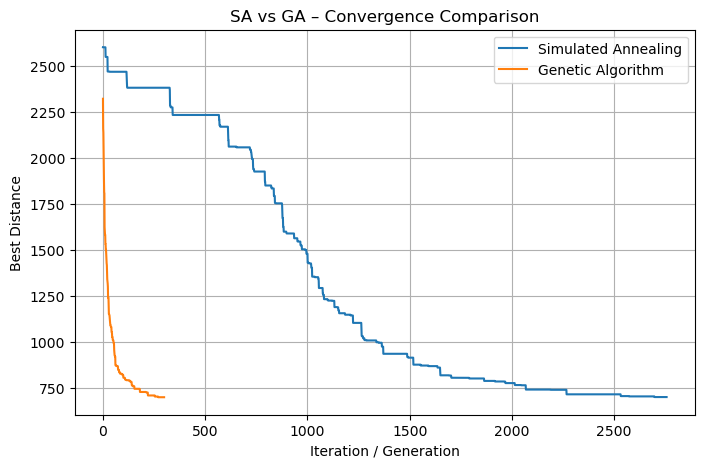

In [101]:
#This plot shows how both algorithms improve their solutions over time

plt.figure(figsize=(8,5))
plt.plot(sa_history, label="Simulated Annealing")
plt.plot(ga_history, label="Genetic Algorithm")
# Label the X-axis: it represents step number (iterations or generations)
plt.xlabel("Iteration / Generation")
# Label the Y-axis: it represents the best distance found so far
plt.ylabel("Best Distance")
plt.title("SA vs GA – Convergence Comparison")
#Show the legend so we can see which line belongs to which algorithm
plt.legend()
## Add a grid to make the plot easier to read
plt.grid(True)
# Displaying the plot
plt.show()


## Scalability Analysis

In the scalability is assessed by performing tests of Simulated Annealing (SA) and Genetic Algorithm (GA) on increasing problem sizes of 10, 20, 30, 40, and 50 cities. This evaluation takes into account the trade offs between solution quality and computational time in relation to the problem size enlargement.

In [86]:

import time

# List of different city sizes we want to test.
# This helps us check how algorithms perform as the problem becomes bigger.
city_sizes = [10, 20, 30, 40, 50]

# Empty list to store results for each city size
scalability_results = []

# Loop through each city size.
for size in city_sizes:
    # Subset cities
    sub_coords = coords[:size]
    sub_dist = build_distance_matrix(sub_coords)

    # --- Simulated Annealing ---
    start = time.time()
    _, sa_cost_sub, _ = simulated_annealing(sub_dist)
    sa_time_sub = time.time() - start

    # --- Genetic Algorithm ---
    start = time.time()
    _, ga_cost_sub, _ = genetic_algorithm(sub_dist)
    ga_time_sub = time.time() - start
# We save all results in a dictionary and append it to our list
# Number of cities tested
    scalability_results.append({
        "Cities": size,
        "SA Distance": sa_cost_sub,
        "SA Time (s)": sa_time_sub,
        "GA Distance": ga_cost_sub,
        "GA Time (s)": ga_time_sub
    })


In [87]:
# Convert results into a clean table format (DataFrame) for easy viewing
scalability_df = pd.DataFrame(scalability_results)
# Display the table
scalability_df


,Cities,SA Distance,SA Time (s),GA Distance,GA Time (s)
0,10,290.306774,0.099508,290.306774,4.867315
1,20,386.429689,0.164874,386.626677,7.176564
2,30,460.669770,0.127816,540.911799,7.308639
3,40,567.657998,0.115233,634.601613,11.494022
4,50,680.844865,0.162560,837.389488,15.187037


## Scalability Analysis

In this part we are analyze the scalability of the Simulated Annealing and the Genetic Algorithm , and for that the two algorithms are tested on increasingly bigger problem sizes of 10, 20, 30, 40, and 50 cities. The intention is to study how the quality of the solutions and the time taken for computations change with the increasing complexity of the TSP instance.

The results shows that Simulated Annealing has the method with the least computation time almost throughout the whole range of problem sizes, which is a clear indication of very good scalability. Also, at the time when Simulated Annealing takes a slight increase in its next city count, the Genetic Algorithm by contrary gets a more extended tour length, which means the problem is more complex than before. However, the increase in execution time owing to the population-based characteristic of the Genetic Algorithm is really high in contrast with the case of Simulated Annealing, which is still keeping its computational efficiency.


# Comparison Discussion

It is claimed that Simulated Annealing reaches the optimum quickly and is also good in terms of computational cost, but on the other hand, it can be caught in local optima due to the stochastic acceptance of poorer solutions.

On the other hand, the Genetic Algorithm preserves a group of solutions that make it possible to explore the search area more thoroughly. This sometimes leads to a better quality of solution, but it is at a price of an increase in the time taken for computation.

Thus, Simulated Annealing is the method of choice when speed is the main requirement, while the Genetic Algorithm is the advanced approach when more resources are available for the in-depth exploration of the problem.